# Part 2 - Integrating Single Cell and Spatial RNA-Seq Data


**ETA**: 30min<br>
**Main Topics**: 
1. Integration with Single Cell RNA-seq data
2. Finding patterns of cell co-localization
3. TLS-site
 1. Identification
 2. Prediction (Optional)
 3. Characterization (Optional)
 
**Information**:
In this part, we explore how single cell and spatial (Visium) data may be integrated in order to leverage the strengths from respective technique. While many interpretations of the concept _integration_ exist, in the context of this exercise it translates into inferring the distribution of cell populations (e.g., types or clusters) from the single cell data within the spatial data. I tend to use the verb _map_ when referring to the process of integration, given how the entities are "mapped" from one space (single cell) to another (spatial). 

Several methods have been suggested for this purpose, one example being _MIA_ (Multimodal intersection analysis, Itai et.al.), and shown success in their application. However, in our analysis we will be using [stereoscope](1); due to the simple reason that I'm most familiar with this method, being the person who developed it. In short, _stereoscope_:

1. Models observations from both modalities (single cell and spatial) as negative binomial
2. Learns the parameters characterizing the NB-distribution of each gene within respective cell type from the single cell data
3. Within each spot, tries to find the combination of cell types (proportions) that best explains the observed expression values


<img src="imgs/stereoscope.png">

Some of the <span style="color:green;font-weight:bold">advantages</span> with using this probabilistic approach are:

* It is not dependent on marker genes, but utilize the whole expression profiles during inference. This can be particularly useful when; one is working with complex tissues where many - and similar - cell types are present; if marker genes are expressed at low levels; if no defined set of marker genes exists.
* It accounts for asymmetries in the data, by introducing a "dummy" cell type into the model
* The obtained values represent actual _proportions_ and not abstract values, i.e., they are interpretable

The major <span style="color:red;font-weight:bold">disadvantage</span> is that the inference is fairly slow. Depending on the size of your dataset it may take up to 24h on a good GPU. You will therefore be given the inferred proportions, in conjunction with information regarding how they were obtained - allowing you to focus on the downstream analysis.

To see how the mapped single cell data can be used for subsequent analysis, we will characterize patterns of cell co-localization, and then continue to with a small analysis of Tertiary Lymphoid Structures (TLSs).

I've marked some topics as "**Optional**" as to indicate that these might be skipped if time is sparse out and you feel as if you have more interest in the content presented in Part 3.

**Data**: We will use the same spatial data as in the previous part (Human Breast Cancer). The single cell data has not yet been published so unfortunately you will not be given access to the raw data (generated by the [Swarbrick Lab][1] at Garvan Institute, Australia), but only the proportion estimates.

[1]:https://www.garvan.org.au/research/cancer/tumour-progression

In [327]:
#------NON-CONCEPTUAL------#

# begin by loading the different modules that we will be using

import anndata as ad
import numpy as np
import pandas as pd

import funcs as f

import matplotlib.pyplot as plt

from typing import Tuple,Union, List, Dict

from IPython.display import display
import warnings
warnings.filterwarnings("ignore")

I've put some of the functions defined in Part 1 (like `plot_data`) in a module named `funcs`, so we don't have to redefine them again. You can access the methods of `funcs` just as those from any normal python package, i.e. `f.method_name` (we import `funcs` as `f`).

### Data

We are going to use two sections (*sample\_1* and *sample\_2*) rather than just one as in Part 1. The two sections originate from the same source, and are very similar in gene expression as well as morphology; meaning we expect results from any analysis to agree to some extent between the two.

As in Part 1, we load experimental data from a `h5ad` files, and store it in a dictionary.

In [328]:
#------NON-CONCEPTUAL------#

data_pths = dict(sample_1 = "../data/bc/curated/bc-A1.h5ad",
                 sample_2 = "../data/bc/curated/bc-A2.h5ad") 

data = {k:ad.read_h5ad(data_pths[k]) for k in data_pths.keys()}


Upon inspection of our data, we see that all the keys are identical and the only thing that differs are the number of observations (spots under the tissue).

In [329]:
display(data)

{'sample_1': AnnData object with n_obs × n_vars = 3813 × 33514
     obs: 'barcodes', 'under_tissue', '_x', '_y', 'x', 'y'
     var: 'name', 'id', 'n_counts'
     uns: 'fiducial_diameter_fullres', 'image_hires', 'spot_diameter_fullres', 'tissue_hires_scalef',
 'sample_2': AnnData object with n_obs × n_vars = 4015 × 33514
     obs: 'barcodes', 'under_tissue', '_x', '_y', 'x', 'y'
     var: 'name', 'id', 'n_counts'
     uns: 'fiducial_diameter_fullres', 'image_hires', 'spot_diameter_fullres', 'tissue_hires_scalef'}

Let us plot the two sections side-by-side, just to make sure the data is loaded correctly and to give you a sense of what material we are going to work with. We will be using the `plot_data` function from Part 1 for this, imported from `funcs`.

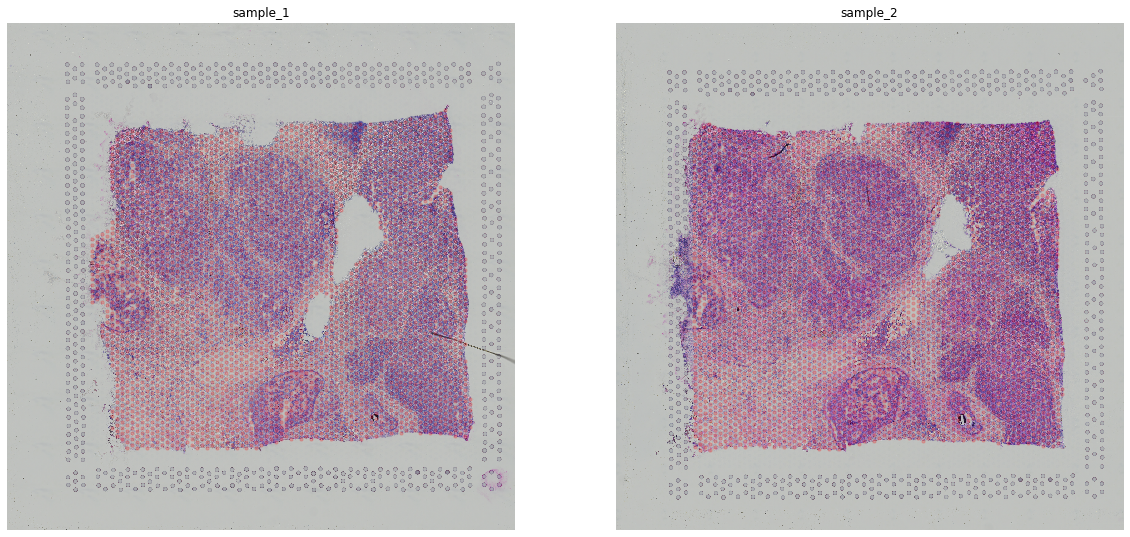

In [330]:
#------NON-CONCEPTUAL------#

# create figure and axes objects
fig,ax = plt.subplots(nrows = 1,
                      ncols = 2,
                      figsize = (20,10))
# style arguments for plot
plt_args = {"s":10, 
            "c":"red",
            "alpha":0.2}

# plot both samples
for ii,(k,v) in enumerate(data.items()):
    f.plot_data(ax[ii],
                v,
                title = k,
                show_image=True,
                plt_args = plt_args,
               )
    
plt.show()

##  Running stereoscope

We are interested to see how different cell types are distributed in our tissue, and will therefore use a single cell data set with cells originating form HER2 positive patients. As mentioned above, we will use `stereoscope` to infer the cell type proportions in each spot. To run the full inference-estimation process of `stereoscope`, you need 3 items:

1. single cell (raw) count data - represented as a `cells x genes` matrix
2. single cell meta data - Where the one column hold the cell type annotations (or cluster labels).
3. spatial count data - represented as a `spot x genes` matrix

`stereoscope` is operated via the terminal by its CLI. Below is the exact command that was used to generate the proportion estimates that we are going to be working with. 

```bash
stereoscope run --sc_cnt SC_COUNT_DATA_PATH --sc_labels SC_META_DATA_PATH --st_cnt ST_COUNT_DATA_PATH -scb 2048 -stb 2048 -sce 50000 -ste 50000 -o OUT_DIR --gpu
```

To elaborate some: `-scb 2048` and `-stb 2048` specify batch sizes of $2048$ for the parameter inference and deconvolution steps respectively. While `-sce 50000` and `-ste 50000` sets the number of epochs for both steps to $50000$, the flag `--gpu` indicates that gpu resources should be used.

For more information regarding `stereoscope` see the documentation on its [github][1] page, where more examples of usage and a "vignette" like walk-through are available.


## Loading proportion estimates

The output from `stereoscope` is, for each section, a `.tsv` file named `W.TAG.tsv` where the `TAG` is unique for the analysis run. I've renamed these to `prop-bc-A1.tsv` and `prop-bc-A2.tsv`. We will load these files and then store their content in the [obsm][2] slot of our `AnnData` objects, assigning them the identifier `scProp`.



[1]: https://github.com/almaan/stereoscope
[2]:https://anndata.readthedocs.io/en/stable/anndata.AnnData.obsm.html?highlight=obsm

In [331]:
#------NON-CONCEPTUAL------#

# dict with proportion paths
prop_pths = dict(sample_1 = "../data/lazy/prop/prop-bc-A1.tsv",
                 sample_2 = "../data/lazy/prop/prop-bc-A2.tsv",
               )

# load proportions and update data objs.
for k,v in prop_pths.items():
    _prop = pd.read_csv(v,
                        sep = '\t',
                        header = 0,
                        index_col =0)
    
    # match rows 
    _prop = _prop.loc[data[k].obs.index,:]
    # update obsm 
    data[k].obsm["scProp"] = _prop

To give you an idea of what cell types we are working with, and what the `stereoscope`output looks like; we may inspect the proportion estimates for *sample\_1*.

In [332]:
#------NON-CONCEPTUAL------#
display(data["sample_1"]\
        .obsm["scProp"]\
        .head())

B-cells_Memory B-cells  B-cells_Naive B-cells  \
CAGGATCCGCCCGACC-1            9.932993e-10           9.912099e-10   
CACGATTGGTCGTTAA-1            9.318246e-10           9.328791e-10   
GGTTGTATCGTGAAAT-1            6.768486e-10           6.758656e-10   
TCTTATGGGTAGTACC-1            1.320812e-09           1.319961e-09   
TACAAGCTGTTCACTG-1            7.769712e-10           7.751594e-10   

                    CAFs_Inflammatory-CAFs  CAFs_Myofibroblast-like CAFs  \
CAGGATCCGCCCGACC-1            1.470833e-02                  1.093455e-02   
CACGATTGGTCGTTAA-1            2.228287e-02                  1.627211e-02   
GGTTGTATCGTGAAAT-1            1.112484e-02                  6.775319e-10   
TCTTATGGGTAGTACC-1            1.318262e-09                  1.777544e-02   
TACAAGCTGTTCACTG-1            7.776088e-10                  1.691945e-02   

                    Endothelial_Lymphatic_endothelial  \
CAGGATCCGCCCGACC-1                       9.924680e-10   
CACGATTGGTCGTTAA-1                       9.354537e-10   
GGTTGTATCGTGAAAT-1                       6.766769e-10   
TCTTATGGGTAGTACC-1                       3.088524e-02   
TACAAGCTGTTCACTG-1                       7.768912e-10   

                    Endothelial_Pericyte-like endothelial cells  \
CAGGATCCGCCCGACC-1                                 9.925437e-10   
CACGATTGGTCGTTAA-1                                 6.605497e-03   
GGTTGTATCGTGAAAT-1                                 6.774350e-10   
TCTTATGGGTAGTACC-1                                 1.321129e-09   
TACAAGCTGTTCACTG-1                                 7.766497e-10   

                    Endothelial_Stalk-like endothelial cells  \
CAGGATCCGCCCGACC-1                              1.542153e-02   
CACGATTGGTCGTTAA-1                              9.355412e-10   
GGTTGTATCGTGAAAT-1                              6.752522e-10   
TCTTATGGGTAGTACC-1                              1.321517e-09   
TACAAGCTGTTCACTG-1                              7.754227e-10   

                    Endothelial_Tip-like endothelial cells  Epithelial_cancer  \
CAGGATCCGCCCGACC-1                            9.926876e-10           0.651932   
CACGATTGGTCGTTAA-1                            9.342128e-10           0.648067   
GGTTGTATCGTGAAAT-1                            6.763982e-10           0.436788   
TCTTATGGGTAGTACC-1                            1.320001e-09           0.587974   
TACAAGCTGTTCACTG-1                            7.765001e-10           0.626081   

                    Epithelial_normal  ...  Myeloid_Macrophage  \
CAGGATCCGCCCGACC-1           0.036470  ...        1.056919e-01   
CACGATTGGTCGTTAA-1           0.083452  ...        9.875477e-02   
GGTTGTATCGTGAAAT-1           0.152378  ...        2.716560e-01   
TCTTATGGGTAGTACC-1           0.086873  ...        9.439593e-02   
TACAAGCTGTTCACTG-1           0.222013  ...        7.783180e-10   

                    Myeloid_Monocyte  Plasmablasts_Plasmablasts  \
CAGGATCCGCCCGACC-1      9.932786e-10                   0.131013   
CACGATTGGTCGTTAA-1      9.340488e-10                   0.070155   
GGTTGTATCGTGAAAT-1      6.785199e-10                   0.049725   
TCTTATGGGTAGTACC-1      1.320406e-09                   0.130806   
TACAAGCTGTTCACTG-1      7.761684e-10                   0.046417   

                    SMCs_Differeniated SMCs  SMCs_Immature SMCs  \
CAGGATCCGCCCGACC-1             9.904483e-10        5.952191e-03   
CACGATTGGTCGTTAA-1             1.998725e-03        9.337567e-10   
GGTTGTATCGTGAAAT-1             6.771882e-10        2.656030e-02   
TCTTATGGGTAGTACC-1             4.078058e-03        1.318808e-09   
TACAAGCTGTTCACTG-1             7.761670e-10        7.766690e-10   

                    T-cells_CD4+ T-cells  T-cells_CD8+ T-cells  \
CAGGATCCGCCCGACC-1          9.897817e-10          9.908186e-10   
CACGATTGGTCGTTAA-1          9.321606e-10          5.373991e-03   
GGTTGTATCGTGAAAT-1          1.687219e-02          6.765660e-10   
TCTTATGGGTAGTACC-1          1.321225e-09          1.320731e-09 

In total we have 22 cell types, which are:

In [333]:
#------NON-CONCEPTUAL------#
display(pd.DataFrame(data["sample_1"]\
                     .obsm["scProp"]\
                     .columns,
                     columns = ["Types"]))

Types
0                        B-cells_Memory B-cells
1                         B-cells_Naive B-cells
2                        CAFs_Inflammatory-CAFs
3                  CAFs_Myofibroblast-like CAFs
4             Endothelial_Lymphatic_endothelial
5   Endothelial_Pericyte-like endothelial cells
6      Endothelial_Stalk-like endothelial cells
7        Endothelial_Tip-like endothelial cells
8                             Epithelial_cancer
9                             Epithelial_normal
10                              Myeloid_Cycling
11                                  Myeloid_DCs
12                           Myeloid_Macrophage
13                             Myeloid_Monocyte
14                    Plasmablasts_Plasmablasts
15                      SMCs_Differeniated SMCs
16                           SMCs_Immature SMCs
17                         T-cells_CD4+ T-cells
18                         T-cells_CD8+ T-cells
19                              T-cells_Cycling
20                             T-cells_NK cells
21                                  T-cells_NKT

Let us visualize $4$ of these cell types in respective sample, being:

* T-cells_CD4+ T-cells
* B-cells_Memory B-cells
* Epithelial_cancer
* Plasmablasts_Plasmablasts

I encourage you to inspect more of the different types, these were quite arbitrarily choosen (maybe some cherries were picked). To do this, just add/remove the names of the cell types to the list `plot_types`.

As you may see, there is concordance between the two sections, and the cell types exhibit quite distinct spatial patterns.

AttributeError: 'AnnData' object has no attribute 'items'

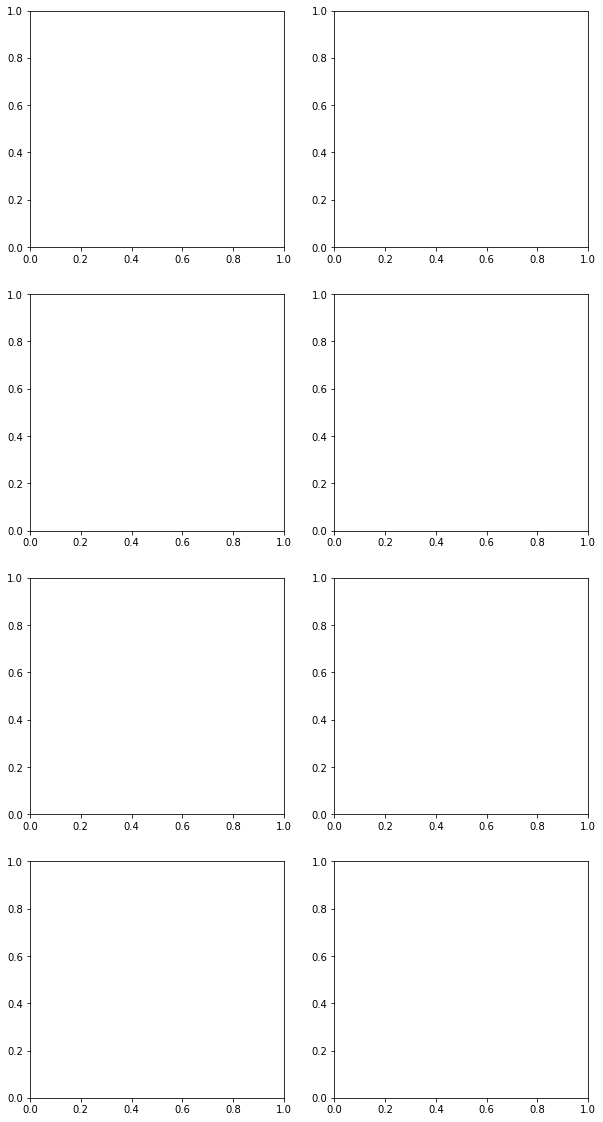

In [355]:
#------NON-CONCEPTUAL------#

# specify cell types to plot
plot_types = ["T-cells_CD4+ T-cells",
              "B-cells_Memory B-cells",
              "Epithelial_cancer",
              "Plasmablasts_Plasmablasts"]

# create figure and axes objects
fig,ax = plt.subplots(nrows = len(plot_types),
                      ncols = 2,
                      figsize = (10,5 * len(plot_types)))

# plot cell types for each sample
for row,cell_type in enumerate(plot_types):
    for ii,(k,v) in enumerate(data.items()):
        # style dict for plot
        plt_args = {"s":10,
                    "c":data[k]\
                    .obsm["scProp"][cell_type]\
                    .values,
                    "alpha":0.2,
                    "cmap":plt.cm.Reds,
                   }
        # update axes
        f.plot_data(ax[row,ii],
                    v,
                    title = " | ".join([k,cell_type]),
                    show_image=True,
                    plt_args = plt_args,
                   )
plt.show()

## Cell type co-localization

In theory, we could just visualize all the cell types like we did above and visually inspect the result - to then make a statement regarding which cell types that seem to be localized together (or spatially anticorrelate). While possible, this approach does not really scale with the number of cell types and it's hard to make a _quantitative_ estimate regarding the degree of co-localization. 

To condense our results into something that is a bit more digestible and easy to overlook, but also can be used as a quantitative metric - we will calculate the _Pearson_ correlation between all cell types. A large positive correlation value will be indicative of a high degree of spatial co-localization, with the opposite being true for large negative values.


Before doing this calculation, let us merge our two `AnnData`-objects into one, to facilitate a joint analysis of our sections. The "helper" function called `join_data`, will take care of this.

One more helper function, `get indices`, is defined below. `get_indices` returns the indices for all observations associated with a specified sample.

**NOTE**: The `join_data` partially relies on the `anndata.AnnData.concatenate` method, see [link][1] for more information of its behavior.

[1]:https://anndata.readthedocs.io/en/stable/anndata.AnnData.concatenate.html

In [346]:
#------NON-CONCEPTUAL------#

def join_data(data : Dict[str,ad.AnnData],
              )-> ad.AnnData:
    
    """Join Spatial Data Objects
    
    Parameters:
    ----------
    data : Dict[str,ad.AnnData]
        data object to join
        
    Returns:
    -------
    AnnData with all data
    from provided objects
    
    """
    
    # prepare new uns dict
    uns : dict  =  {n:{} for n in \
                   range(len(data))}

    # transfer uns from respective
    # sample to joint dict
    for n,d in enumerate(data.values()):
        for k,v in d.uns.items():
            uns[n].update({k:v}) 

    # get key of first data object
    k0 : str = next(iter(data.keys()))
    # get first data object
    d0 : ad.AnnData = data.pop(k0)

    # merge samples, join on 
    out : ad.AnnData = d0.concatenate(*list(data.values()),
                                     join = "outer",
                                     batch_key = "sample",
                                     index_unique = "-")
    out.uns : dict = uns

    return out


def get_indices(data : ad.AnnData,
                label : Union[int,str],
                category : str = "sample",
               )-> np.ndarray:
    
        """Get indices of sample
        
        Parameters:
        
        data : ad.AnnData
            data object containing one or more
            samples
        label : Union[int,str]
            sample index to fetch indices for
        category : str
            key for object holding
            sample indicators in
            obs
            
        Returns:
        --------
        Indices of elements
        belonging to a specific
        samples
            
        """
        
        idx = np.where(data.obs[category] == label)[0]
        
        return idx

In [341]:
# Join sample_1 and sample_2 together
data = join_data(data)

AttributeError: 'AnnData' object has no attribute 'values'

**Note**: The new `data` object behaves similar to the objects we've worked with so far, the only two things that really differs are:

1. the addition of a `sample` element to our `obs` attribute, this indicates which sample each observation is associated with
2. `uns` now holds two keys referring to the sample indices, when accessed via the sample index we get a dictionary with the same structure as when handling a single section (see below).

In [311]:
# accessing the uns data of sample_1 (index 0)
display(data.uns[0].keys())

dict_keys(['fiducial_diameter_fullres', 'image_hires', 'spot_diameter_fullres', 'tissue_hires_scalef'])

In the next step we will define a function `get_correlations` which - surprise -  provides us with correlation values between the different cell types. More specifically, it takes as input an `AnnData` object and information regarding which features that the correlation should be computed between, it then returns a `pandas DataFrame` holding the correlation values.

In [347]:
#------NON-CONCEPTUAL------#
from scipy.stats import pearsonr
def get_correlations(data : ad.AnnData,
                     prop : str = "obsm",
                     feature : str = "scProp",
            )-> pd.DataFrame:
    
    """Generate correlation matrix
    
    Parameters:
    ----------
    
    data : ad.AnnData
        data containing feature to correlate
    prop : str
        attribute that holds feature to
        correlate
    feature : str
        name of feature to correlate
    
    Returns:
    -------
    Correlation matrix
    
    """

    vals = eval("data" + "." + prop )[feature]
    types = vals.columns.values
    n_types = len(types)
    cmat = np.diag(np.ones(n_types))
    cmat = pd.DataFrame(cmat,
                        columns = types,
                        index = types,
                       )
    
    for i,type_1 in enumerate(types):
        for j,type_2 in enumerate(types):
            if j < i:
                r,_ = pearsonr(vals[type_1].values,
                               vals[type_2].values)
                cmat.loc[type_1,type_2] = r
                cmat.loc[type_2,type_1] = r
    return cmat

Now, apply `get_correlations` to our data:

In [348]:
cmat = get_correlations(data)

To visualize the correlation matrix we may use `matplotlib`'s `imshow` function. Which would look something like:

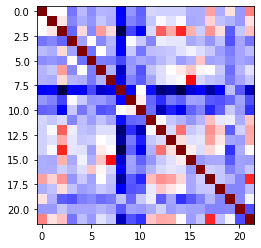

In [349]:
plt.imshow(cmat,
           aspect = "equal",
           cmap = plt.cm.seismic)
plt.show()

We can see how  some cell type pairs correlate or anti-correlate quite strongly; but aside from that, the plot is not extremely informatiive . We thus proceed by defining a function (`plot_correlations`) that renders a somewhat more refined representation of the correlation values.

In [352]:
#------NON-CONCEPTUAL------#

def plot_correlations(ax : plt.Axes,
                      cmat : pd.DataFrame,
                     )-> None:
    """Fancy Correlation Visualization
    
    Parametes:
    ---------
    
    ax : plt.Axes
        axes object to plot in
    data : pd.DataFrame
        correlation matrix
        
    Returns:
    -------
    None
    
    """
    ax.imshow(cmat,
              cmap = plt.cm.seismic)
    ax.set_aspect("equal")
    
    x_ticks = np.arange(cmat.shape[1])
    y_ticks = np.arange(cmat.shape[0])
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(cmat.columns.values,
                       rotation = 90)
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(cmat.index.values)
    ax.set_ylim([cmat.shape[0]-0.5,-0.5])

Providing  our correlation matrix (`cmat`) as input to `plot_correlations`, we obtain the following representation:

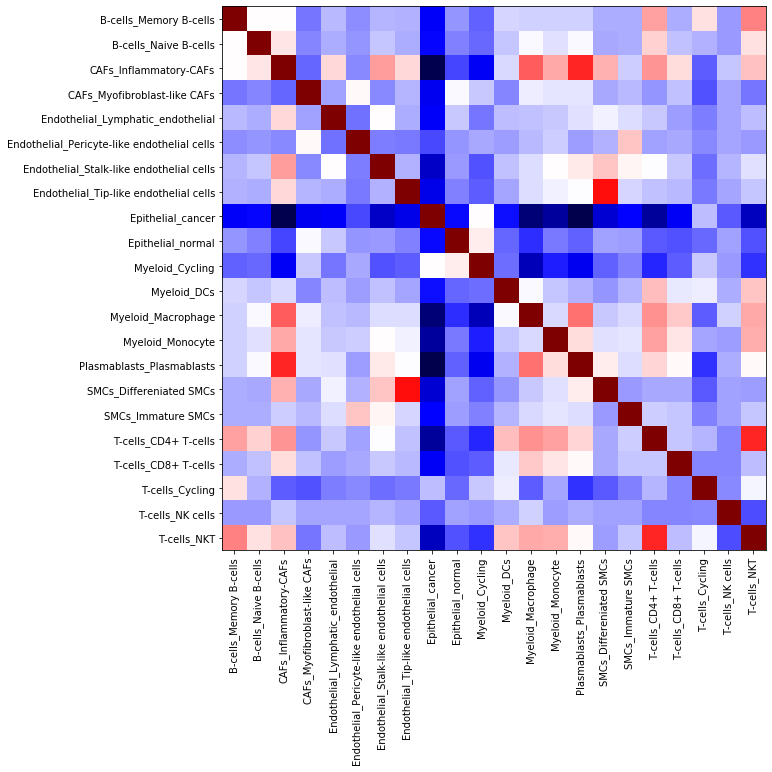

In [354]:
fig, ax = plt.subplots(nrows = 1,
                       ncols = 1,
                       figsize = (10,10),
                      )

plot_correlations(ax,cmat)

## Charting TLS-Sites

This study of co-localization presents us with several intriguing signals worth pursuing further, but we will choose to focus on one: the correlation between B and T-cells (more explicitly Memory B Cells and CD4+ T-cells). A correlation between these two cell types is of certain interest because joint presence of them might be indicative of [*Tertiary Lymphoid Structures*][1] which are known to:

* Partially dictate the degree of TILs (Tumor Infiltrating Lymphocytes) in cancers
* Have implications in tumor treatment and outcome

**Comment**: In the upcoming analysis I will for the sake of brevity refer to _Memory B Cells_ and _CD4+ T-cells_ as B and T-cells respectively, despite us actually working with subclasses of these.

### Identification

First, we will assess which spots that have high proportions of both B and T-cells. The easiest way of doing this is to simply cross-multiply the proportion values of the two types (if we were to think of the tissue as a matrix, this would be equivalent to element-wise multiplication). By doing so, we obtain a metric which we (somewhat arrogantly) will call a "_TLS-score_". This TLS-score is expected to behave as follows:

|B-cell proportion | T-cell proportion | TLS-score|
|----|----|----|
|Low | Low | Low|
|High| Low | Low|
|Low | High| Low|
|High| High| High|

or visualized as a function surface:

<img src="imgs/landscape.png">

This is behavior (similar to the logical `AND` operator) is a consequence of multiplying small numbers ($\leq1$). You can see the manifestation of this as we plot the proportions and the TLS-score below.

[1]:  https://doi.org/10.1038/s41568-019-0144-6

In [357]:
# set column names for b and t cells
b_cells = "B-cells_Memory B-cells"
t_cells = "T-cells_CD4+ T-cells"

# compute TLS-score
tls_score = data.obsm["scProp"][b_cells] * data.obsm["scProp"][t_cells]

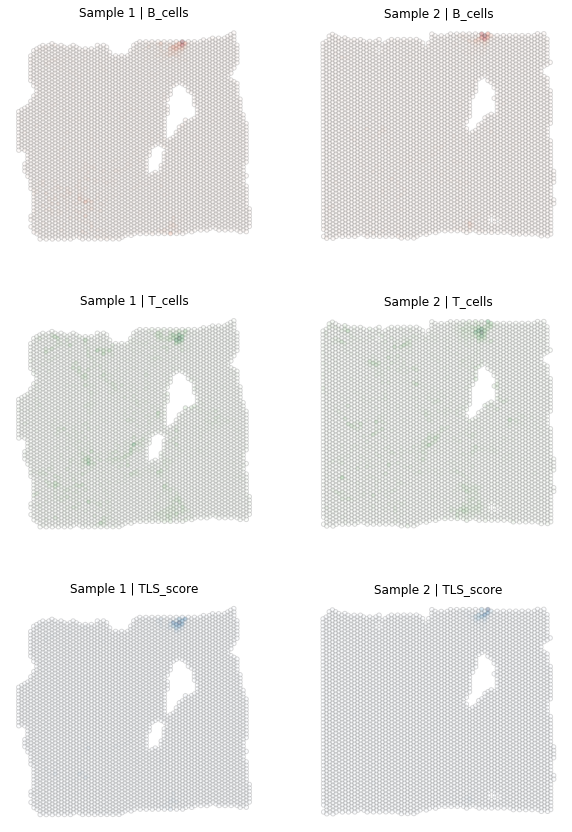

In [358]:
#------NON-CONCEPTUAL------#

# create figure and axes objects
fig,ax = plt.subplots(nrows = 3,
                      ncols = 2,
                      figsize = (5*2,5*3))

# specify colors for plot
vals = dict(B_cells = (data.obsm["scProp"][b_cells],
                       plt.cm.Reds),
            T_cells = (data.obsm["scProp"][t_cells],
                       plt.cm.Greens),
            TLS_score = (tls_score,plt.cm.Blues),
           )

# plot proportion and scores
for row,(feature,specs) in enumerate(vals.items()):
    for k,sample in enumerate(np.unique(data.obs["sample"])):
        idx = get_indices(data,sample)
        f.plot_data(ax[row,k],
                    data[idx],
                    plt_args = {"c":specs[0][idx],
                                "cmap":specs[1],
                                "alpha":0.3,
                                "edgecolor":"gray",
                                "s":20,
                               },
                    show_image = False,
                    index = int(sample),
                    title = "Sample {} | {}".format(k + 1, feature)
                   )

### Prediction (Optional)

One thing that would be interesting is to see which genes that are associated with a _high_ TLS-score. Note how this is different from asking which genes that are markers for B and T-cells, since we condition it on the joint presence of both cell types. We will make use of the fact that we have almost $7000$ data points with an assigned TLS-score and known gene expression. From this we may construct a simple model to predict TLS-score based on gene expression. 

We let $y_s$ denote the adjusted (more on this soon) TLS-score in spot $s$, and $x_{sg}$ the normalized gene expression value of spot $s$ and gene $g$. Then, we will model $y_s$ as a function of the gene expression within that spot $\boldsymbol{x}_s$, more specifically:

\begin{equation}
y_s = \beta_0 + \boldsymbol{\beta}^T\boldsymbol{x}_s + \varepsilon_s, \quad \beta_0 \in \mathbb{R}, \quad 
\boldsymbol{\beta} \in \mathbb{R}^G,
\end{equation}

You may recognize this as a simple linear model, where $\beta_0$ represent the intercept and the remaining $\beta$'s are coeffeficents associated with each gene ($g$). Note how the coefficients are not dependent on spot ($s$). The higher the value of $\beta_g$ is, the higher (positive) impact does gene $g$ have on the $y_s$-value. Meaning that the $\beta$-values can be used to extract a set of TLS-related genes. The terms $\varepsilon_s$ represents random noise that is presented in the data.

To find the $\beta$ values we will use ElasticNet regression (ordinary least squares with penalty terms), implemented in the `scikit-learn` package. The [ElasticNet][1] uses a combination of L1 and L2 penalty terms, where the former is helpful for feature selection and the latter to reduce overfitting when working with datasets where $n_{observation} << n_{features}$.

We normalize the expression data by first dividing expression values by library size (within each spot) and then the standard deviation (within each gene). In addition, we will also filter genes with low abundance (observed in less than 1\% of the spots). This normalization is implemented in the `prepare_data`function below.

The adjusted TLS-score, is a slight redefinition of our previous score. It's based on the idea that we from a given spot in theory could randomly "pick" a pair of two cells. More precisely we:

1. Compute the probability that the pair consist of one B and one T-cell (from the proportion values)
2. Subtract the expected probability of this event happening if no bias between the cell types existed (all cells having equal probability of being picked)

This means that our response variable ($y_s$) will have both positivie and negative values, and not only positive ones, which is in concordance with the model we are using. It also introduces a form of natural "cutoff" for the adjusted score. The function `adjust_score`is used to compute the adjusted TLS-score.

[1]:https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html#sklearn.linear_model.ElasticNet

In [395]:
#------NON-CONCEPTUAL------#

def prepare_data(cnt: pd.DataFrame,
                 do_filter : bool = False,
                )->pd.DataFrame:
    
    """Prepare data for TLS-prediction
    
    Parameters:
    -----------
    
    cnt : pd.DataFrame
        count data
    do_filter : bool
        conduct quality filtering
        
    Returns:
    -------
    Prepared expression data
    to be used as input to 
    regression
    
    """
    
    # get spot library sizes
    libSize = cnt.values.sum(axis = 1,
                             keepdims= True)
    
    # get number of observation for genes
    nObs = (cnt.values > 0).sum(axis = 0,
                                keepdims = True)

    # normalize by library size
    cnt = pd.DataFrame(cnt.values /\
                       cnt.values.sum(axis = 1,
                                      keepdims = True),
                       index = cnt.index,
                       columns = cnt.columns,
                       )

    # get std's for genes
    std = cnt.values.std(axis=0,
                         keepdims = True)

    # normalize genes by stds
    cnt = pd.DataFrame(np.divide(cnt.values,std,
                                 where = std > 0),
                        index = cnt.index,
                        columns = cnt.columns,
                       )

    # filter spots and gens if specified
    if do_filter:
        keep_genes = nObs.flatten() > cnt.shape[0]*0.01
        keep_spots = libSize.flatten() > 0
        cnt = cnt.iloc[keep_spots,keep_genes]
    
    return cnt

def adjust_score(y : np.ndarray,
                 n_types : int,
                )->np.ndarray:
    """Compute adjusted scores
    
    Parameters:
    ----------
    y : np.ndarray
        unadjusted TLS-score
    n_types: int
        number of cell types present
    
    Returns:
    -------
    Adjusted score
    
    """
    
    n_y = 2*(y - 1.0 / n_types**2)
    
    return n_y

We train the model on one section (*sample\_1*) and use the other (*sample\_2*) to evaluate the performance and assess the presence/extent of overfitting.

The first step is to normalize the expression data and compute the adjusted TLS-score:

In [396]:
# get indices for sample 1
sel_idx = get_indices(data,"0")

# create training data frame
train_cnt = pd.DataFrame(data.X[sel_idx,:],
                   columns = data.var["name"],
                   index = data.obs.index[sel_idx],
                  )

# prepare training data
train_cnt = prepare_data(train_cnt,
                         do_filter =True)

# add intercept
train_cnt["intercept"] = np.ones(train_cnt.shape[0])

# compute adjusted tls-score
ntls_score = adjust_score(tls_score,
                          n_types = data\
                          .obsm["scProp"]\
                          .shape[1],
                         )

Whereafter we fit the linear model spoken of above:

In [362]:
from sklearn.linear_model import ElasticNet

alpha = 1e-3
l1_ratio = 0.1

model = ElasticNet(alpha = alpha,
                  l1_ratio = l1_ratio,
                  fit_intercept = False)

res = model.fit(train_cnt.values,
                ntls_score[sel_idx])

We will create a `pandas DataFrame` to hold our coefficients, just to make it easier to work with later on.

In [397]:
coef = pd.DataFrame(res.coef_)
coef.index = train_cnt.columns
coef.columns = ["beta"]

 We can compare the predicted (adjusted) TLS-score to the actual score:

In [398]:
train_pred = np.dot(train_cnt.values,
                    coef.values.reshape(-1,1),
                   ).flatten()

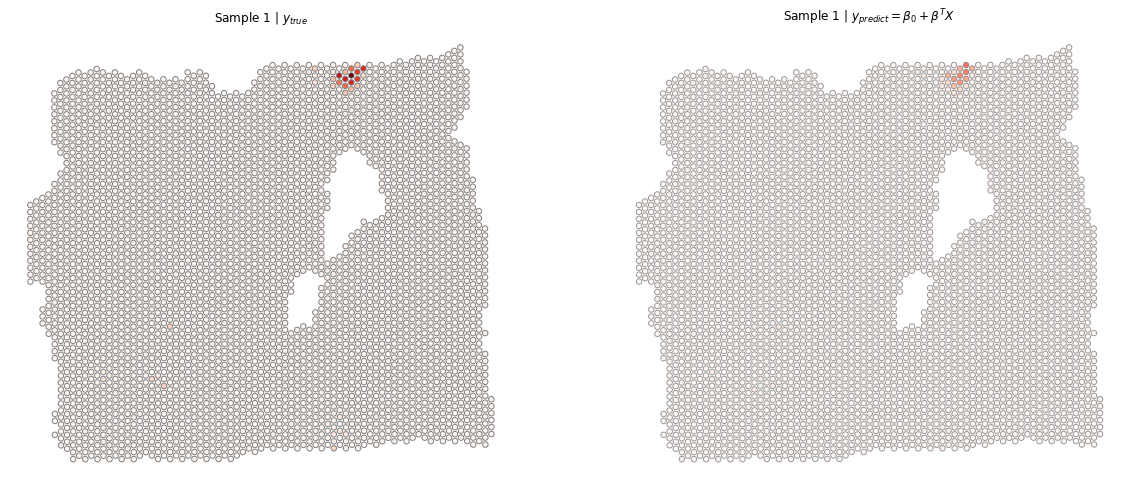

In [399]:
fig,ax = plt.subplots(nrows = 1,
                      ncols = 2,
                      figsize = (20,
                                 10))

vmax = np.max((ntls_score[sel_idx].max(),
               train_pred.max()))

f.plot_data(ax[0],
            data[sel_idx],
            plt_args = {"c":ntls_score[sel_idx],
                        "cmap":plt.cm.Reds,
                        "edgecolor":"gray",
                        "alpha":1.0,
                        "s":30,
                        "vmax":vmax,
                        "vmin": 0,
                         },
                show_image = False,
                index = 0,
            title = "Sample 1 | " + \
                     r"$y_{true}$",
               )

f.plot_data(ax[1],
            data[sel_idx],
            plt_args = {"c":train_pred,
                       "cmap":plt.cm.Reds,
                        "edgecolor":"gray",
                        "s":30,
                        "vmax":vmax,
                        "vmin":0,
                         },
                show_image = False,
                index = 0,
            title = "Sample 1 | " +\
                    r"$y_{predict} = \beta_0 + \beta^TX$",
               )

As we guessed from our inspection of the errors (they were relatively small), the predicted values agree very well with the true ones. Again, had we not applied any penalty terms on the coefficients, this fit would had been even _better_, but at the cost of likely performing worse when presented with _new_ unseen data.

Now, even though we have tried to guard ourselves agains overfitting, we'd still like assure ourselves that the model haven't just learned the structure of the data for the specific tissue section we trained it on. We will therefore apply the fitted model to the second sample, to see whether the predicted values agree with the true ones in this tissue as well.

To do this, we first process the data from *sample\_2* by the exact same procedure as that of *sample\_1*. 

In [400]:
#------NON-CONCEPTUAL------#

sel_idx = get_indices(data,"1")
# create test data frame
test_cnt = pd.DataFrame(data.X[sel_idx,:],
                       columns = data.var["name"],
                       index = data.obs.index[sel_idx],
                      )

# prepare test data
test_cnt = prepare_data(test_cnt)
# add intercept
test_cnt["intercept"] = np.ones(test_cnt.shape[0])
# prepare training data


inter = coef.index.intersection(test_cnt.columns)
test_cnt = test_cnt.loc[:,inter]


In [ ]:
# get indices for sample 1
sel_idx = get_indices(data,"0")

# create training data frame
train_cnt = pd.DataFrame(data.X[sel_idx,:],
                   columns = data.var["name"],
                   index = data.obs.index[sel_idx],
                  )

# prepare training data
train_cnt = prepare_data(train_cnt,
                         do_filter =True)

# add intercept
train_cnt["intercept"] = np.ones(train_cnt.shape[0])

# compute adjusted tls-score
ntls_score = adjust_score(tls_score,
                          n_types = data\
                          .obsm["scProp"]\
                          .shape[1],
                         )

Then we "predict" the adjusted TLS-score from the normalized expression data.

In [401]:
test_pred = np.dot(test_cnt,
                    coef.values.reshape(-1,1),
                  ).flatten()

And - as for *sample\_1* - we visualize the result:

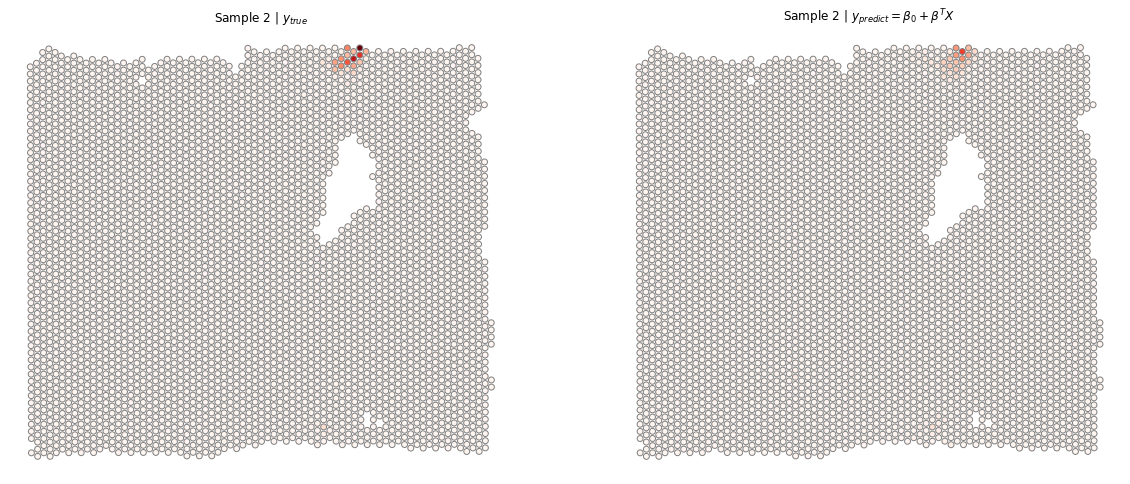

In [402]:
#------NON-CONCEPTUAL------#

fig,ax = plt.subplots(nrows = 1,
                      ncols = 2,
                      figsize = (20,
                                 10))

sel_idx = get_indices(data,"1")
vmax = np.max((ntls_score[sel_idx].max(),
               test_pred.max()))
f.plot_data(ax[0],
            data[idx],
            plt_args = {"c":ntls_score[sel_idx],
                        "cmap":plt.cm.Reds,
                        "edgecolor":"gray",
                        "alpha":1,
                        "s":35,
                        "vmax":vmax,
                        "vmin": 0,
                         },
                show_image = False,
                index = int(sample),
                title = "Sample 2 | " +\
            r"$y_{true}$",
               )

f.plot_data(ax[1],
            data[sel_idx],
            plt_args = {"c":test_pred,
                        "cmap":plt.cm.Reds,
                        "edgecolor":"gray",
                        "alpha":1.0,
                        "s":35,
                        "vmax":vmax,
                        "vmin":0,
                         },
                show_image = False,
                index = int(sample),
                title = "Sample 2 | " +\
            r"$y_{predict} = \beta_0 + \beta^TX$",
               )

The result is not perfect, but it's also not terrible; the predicted values definitely agree with the true ones to some extent. We will settle with these results for now and continue with the analysis.

### Characterization (Optional)

We can construct a "rank-plot" (as in the factor analysis of Part 1) to inspect how the values of our coefficients ($\beta$) behave.

**Note**: I've added a dashed red line at rank $160$, this indicates where we'll make a cutoff to select genes that could be considered as contributing strongly to the TLS-score, making up a form of _signature_.

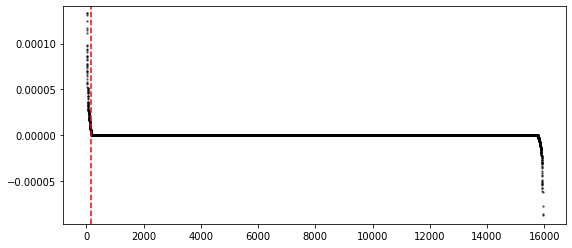

In [222]:

fig,ax = plt.subplots(1,1,figsize=(9,4))

srt_idx = np.argsort(coef\
                     .values\
                     .flatten())[::-1]

coef = coef.iloc[srt_idx]

ax.scatter(np.arange(coef.shape[0]),
           coef.values.flatten(),
           c = "black",
           s = 2,
           alpha = 0.5,
           )

delta = 5e-4
ax.set_ylim(np.quantile(coef.values,delta)*1.1,
            np.quantile(coef.values,1-delta)*0.9)
ax.axvline(x= 160,
           color = "red",
           linestyle = "dashed")
plt.show()

You may notice a very "sharp elbow" in the curve, when compared to the previous rank-plots that we've generated. This is an immediate effect of using a L1 penalty term, which promotes shrinkage of most of coefficients towards zero. 

We continue to inspect the $10$ genes with highest coefficient values.

In [223]:
display(coef.head(10).T)

name    MS4A1       BLK     BANK1     CD3E     FCRLA   RASGRP2  TNFRSF13C  \
beta  0.00057  0.000235  0.000233  0.00023  0.000226  0.000198   0.000194   

name   DBH-AS1   SLC22A3  TBC1D10C  
beta  0.000179  0.000156  0.000152

The presence of these genes  among the top ones is encouraging. Several of them are either associated with B-cells (e.g., [_MS4A1_][1]), T-cells (e.g., [_TRBC2_][2]) or even TLS-sites specifically (e.g., [_LTB_][3] and [_FDCSP_][4]).



[1]: https://www.genecards.org/cgi-bin/carddisp.pl?gene=MS4A1
[2]: https://www.genecards.org/cgi-bin/carddisp.pl?gene=TRBC2
[3]: https://doi.org/10.1038/s41379-018-0113-8
[4]: https://www.biorxiv.org/content/10.1101/2020.02.19.955666v4

We continue to plot the genes' spatial distributions to see if they resonate with our expectations. I'm only plotting the gene expression in *sample\_1*, but feel free to also check them in *sample_2* (to do this, simply change `"0"` in `get_indices`to `"1"`).

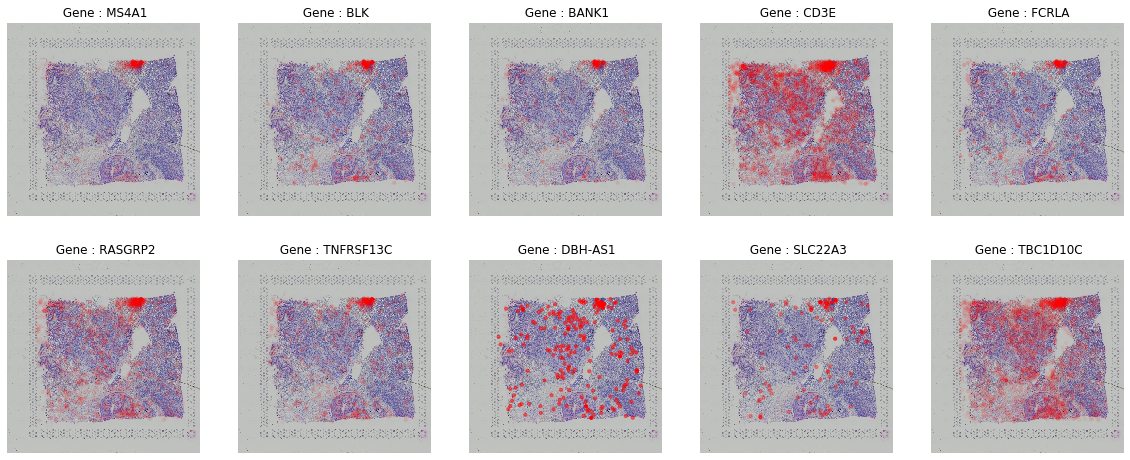

In [224]:
n_top = 10
sel_idx = get_indices(data,"0")
top_genes = coef.index.values[0:n_top]
# specify number of columns when displaying plot grid
n_cols = 5
# get number of rows to use when displaying plot grid
n_rows = np.ceil(n_top / n_cols).astype(int)
# initate plot object
fig,ax = plt.subplots(n_rows,
                      n_cols,
                      figsize = (4*n_cols,4*n_rows))

# make plot-grid 1-dimensional vector
ax = ax.flatten()
# plot each of the top variable genes
for k,gene in enumerate(top_genes):
    f.plot_data(ax[k],
              data,
              feature = ["name",gene],
              plt_args = {"cmap":"feature",
                          "s":10},
              title = " Gene : {}".format(gene),
              clean = True,
               index = 0,
               )
    
for _k in range(k+1,n_rows*n_cols):
    ax[_k].remove()

These genes' expression to overlap with the regions of high TLS-score, which is what we hoped to see. 

As previously mentioned, we select the top ($160$) genes w.r.t. coefficient value, and consider this a _signature_ gene set for the (implied) TLS-sites. Finally we subject the signature set to enrichment analysis (using `g:Profiler`); to see what pathways (if any) our set is enriched for.

In [225]:
from gprofiler import GProfiler

n_sig = 160
# instatiate gprogiler object that can be used for querying
gp = GProfiler(return_dataframe=True)
# query gene set using homo-sapiens as organism
enr_res = gp.profile(organism='hsapiens',
                     query=coef\
                     .index\
                     .values[0:n_sig]\
                     .tolist(),
                    )


In [226]:
enr_res = enr_res.iloc[enr_res["source"].values == "GO:BP",:]
display(enr_res.head(10))

source      native                                          name  \
0  GO:BP  GO:0046649                         lymphocyte activation   
1  GO:BP  GO:0042110                             T cell activation   
2  GO:BP  GO:0002682           regulation of immune system process   
3  GO:BP  GO:0030098                    lymphocyte differentiation   
4  GO:BP  GO:0045321                          leukocyte activation   
5  GO:BP  GO:0001775                               cell activation   
6  GO:BP  GO:0002684  positive regulation of immune system process   
7  GO:BP  GO:0006955                               immune response   
8  GO:BP  GO:0051249           regulation of lymphocyte activation   
9  GO:BP  GO:0002376                         immune system process   

        p_value  significant  \
0  1.021471e-17         True   
1  1.079263e-16         True   
2  8.148972e-16         True   
3  1.941476e-14         True   
4  8.011032e-14         True   
5  1.461611e-13         True   
6  1.661431e-13         True   
7  4.876439e-13         True   
8  6.866532e-13         True   
9  9.095839e-13         True   

                                         description  term_size  query_size  \
0  "A change in morphology and behavior of a lymp...        754         130   
1  "The change in morphology and behavior of a ma...        478         130   
2  "Any process that modulates the frequency, rat...       1688         130   
3  "The process in which a relatively unspecializ...        361         130   
4  "A change in morphology and behavior of a leuk...       1305         130   
5  "A change in the morphology or behavior of a c...       1465         130   
6  "Any process that activates or increases the f...       1199         130   
7  "Any immune system process that functions in t...       2294         130   
8  "Any process that modulates the frequency, rat...        509         130   
9  "Any process involved in the development or fu...       3235         130   

   intersection_size  effective_domain_size  precision    recall    query  \
0                 37                  17906   0.284615  0.049072  query_1   
1                 30                  17906   0.230769  0.062762  query_1   
2                 50                  17906   0.384615  0.029621  query_1   
3                 25                  17906   0.192308  0.069252  query_1   
4                 42                  17906   0.323077  0.032184  query_1   
5                 44                  17906   0.338462  0.030034  query_1   
6                 40                  17906   0.307692  0.033361  query_1   
7                 54                  17906   0.415385  0.023540  query_1   
8                 27                  17906   0.207692  0.053045  query_1   
9                 64                  17906   0.492308  0.019784  query_1   

                                parents  
0                          [GO:0045321]  
1                          [GO:0046649]  
2              [GO:0002376, GO:0050789]  
3              [GO:0002521, GO:0046649]  
4              [GO:0001775, GO:0002376]  
5                          [GO:0009987]  
6  [GO:0002376, GO:0002682, GO:0048518]  
7              [GO:0002376, GO:0050896]  
8              [GO:0002694, GO:0046649]  
9                          [GO:0008150]

Judging from the top listed processes, it seems as if our gene set is not completely random, but rather strongly  associated with differentiation and activation of cells (especially immune related types). When all our results are weighted together, we may at least say that support for further inquiry exists. This is however where Part 2 stops, in order to give you some time for questions and to try out Part 3.

## Wrapping up Part 2

We've familiarized ourselves with the concept of integrating single cell and spatial data, while also peeking into what type of subsequent analysis that might be performed after this has been done. With all of the emerging _atlases_ (single cell as well as spatial) I'm convinced that we have an exciting time ahead of us, where many new discoveries can be made by combining the two modalities - a statement that is true independent of platforms or methods used in the process.


I've set aside 10 minutes for question after the completion of this part. As before, don't hesitate to start with the next part if it took you less time than expected to work through the material.